In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import scipy, os
from sklearn.metrics import confusion_matrix
import seaborn as sns

import sys
sys.path.append('../../Share/')
sys.path.append('../../Share/Manual_processing/')
import baseline, config, Model, utils, Same_with_MATLAB, Feature_info

import warnings
warnings.filterwarnings('ignore')


def restore_labels(mat, labels_windowed):

    original_length = mat['Data_ADC'].shape[1]
    win_size = 600 #Original
    win_step = 120
    valid_length = original_length - 2 * 60

    label_full = np.zeros(original_length, dtype=labels_windowed.dtype) # 복원될 시계열 레이블 (원본 길이)

    # 슬라이딩 윈도우 인덱스 따라 레이블 채워넣기
    for i, label in enumerate(labels_windowed):
        start = 60 + i * win_step
        end = start + win_size
        if end <= original_length - 60:
            label_full[start:end] = label

    return label_full


def filtering_zero(X, y, erase_label):
    # 1. erase_label 제거
    keep_indices = y != erase_label
    X = X[keep_indices]
    y = y[keep_indices]

    # 2. erase_label보다 큰 값은 1씩 감소
    y = np.where(y > erase_label, y - 1, y)

    return X, y

def vis_graph(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

def heatmap_confusion_matrix(X_test, y_test, model):
    # Predict class labels on the test set
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)  # convert softmax probs to predicted class
    y_true = y_test
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(np.max(y_test)+1), yticklabels=range(np.max(y_test)+1))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


from collections import Counter

def balance_data(X, y):
    # Count samples per class
    class_counts = Counter(y)
    min_count = min(class_counts.values())  # target: balance all to minority count

    indices_list = []

    for label in sorted(class_counts.keys()):
        label_indices = np.where(y == label)[0]
        selected_indices = np.random.choice(label_indices, size=min_count, replace=False)
        indices_list.extend(selected_indices)

    # Shuffle all selected indices
    balanced_indices = np.random.permutation(indices_list)

    # Subset the data
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]

    return X_balanced, y_balanced


In [3]:
fs, lower_cutoff, upper_cutoff = Feature_info.fs, Feature_info.lower_cutoff, Feature_info.upper_cutoff
# fs, lower_cutoff, upper_cutoff = Feature_info.fs, 1, 300
filter_b, filter_a = Same_with_MATLAB.cheby2(4, 30, [lower_cutoff / (fs/2), upper_cutoff / (fs/2)], btype='bandpass')

In [3]:
#path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-07-30/E9AD0E7DCC2B/raw/'
path = 'C:/Users/hml76/Documents/MATLAB/data/Exp_2025-08-01/E9AD0E7DCC2B/raw/'


data_per_class_files = os.listdir(path)
X, y = [], []

for cls in data_per_class_files:
    input_path = path+cls+'/'
    files = os.listdir(input_path)
    mat = scipy.io.loadmat(input_path+files[0])
    label = mat['Data_Cls'].reshape(-1)  # shape: (1, 1729)

    feat_mean = np.tile(Feature_info.feat_mean_lst, (4, 1))
    feat_std = np.tile(Feature_info.feat_std_lst, (4, 1))

    mapped_label = np.where(label == 0, 0, int(cls))
    restored_label = restore_labels(mat, mapped_label)

    #print(mat['Data_ADC'].shape, mat['Data_Cls'].shape, restored_label.shape)
    extractor = Same_with_MATLAB.EMGFeatureExtractor(feat_mean, feat_std, filter_b, filter_a, Norm_bool=True, num_feature_set=14) #I tried 23, but not so good
    extractor.buffer = mat['Data_ADC']
    #1000, 50 = winsize and winstep
    features, labels = extractor.extract_features_with_labels(win_size=2000, win_step=50, feat_exclude=25, filtering=False, restored_label=restored_label) #Same with
    #features, labels = extractor.extract_features_with_labels(win_size=2000, win_step=50, feat_exclude=25, filtering=True, restored_label=restored_label)

    features = np.transpose(features, (2, 0, 1))  # shape: (1729, 4, 14)
    X.append(features)
    y.append(labels)
    #print(features.shape, labels.shape)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
#X = X[:, :, :, np.newaxis]
print(pd.Series(y).value_counts())
print(X.shape, y.shape)

0    30513
2      434
4      433
5      429
7      427
8      417
1      416
6      389
3      388
Name: count, dtype: int64
(33846, 4, 14) (33846,)


Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 46.08%
Maximum validation accuracy : 49.16%


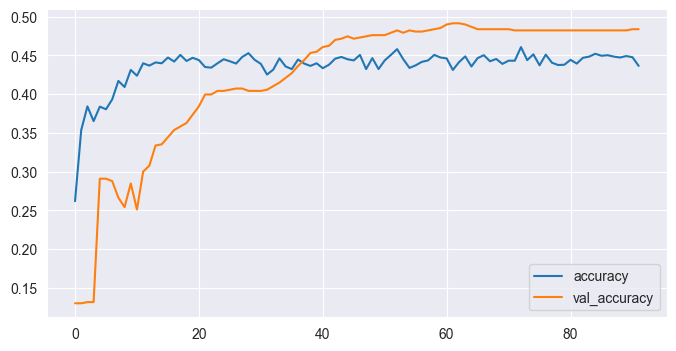

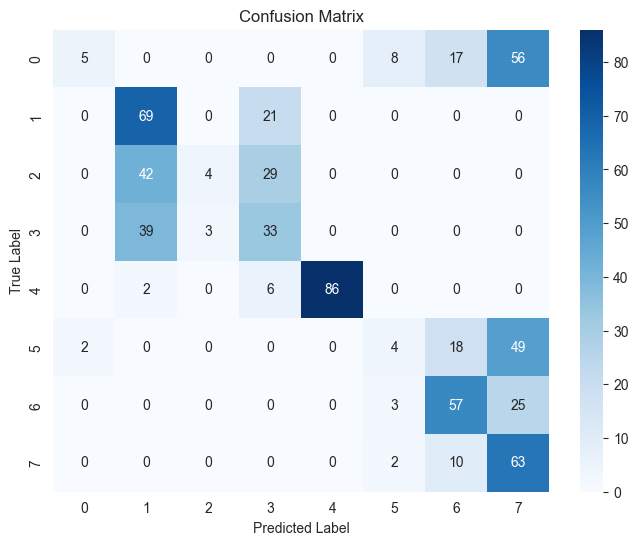

Start Training (total epochs: 200)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 45.49%
Maximum validation accuracy : 51.45%


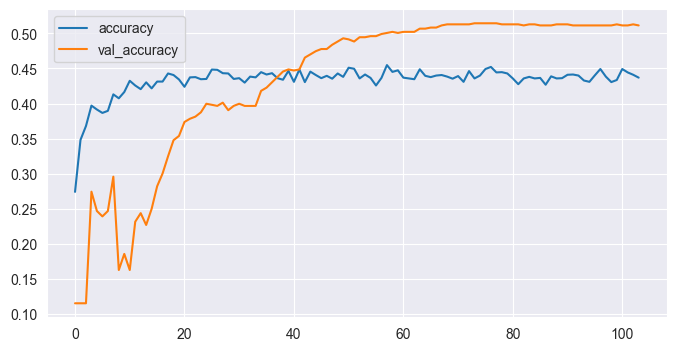

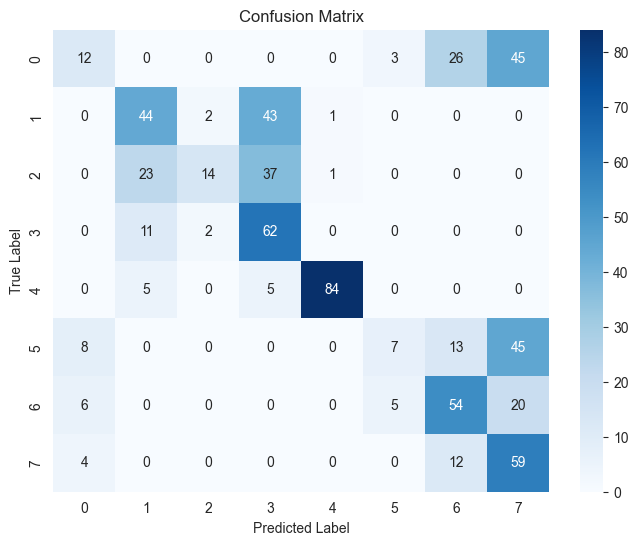

In [4]:
import importlib
importlib.reload(Model)

X_train, y_train, X_test, y_test  = utils.split_data(X, y, train_ratio=0.8)
X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)
ACC_lst = []

for feature_idx in [2, 10]:
    One_X_train = X_train[:, :, feature_idx, :]
    One_X_test = X_test[:, :, feature_idx, :]

    model = Model.Original_model_1DCNN(One_X_train.shape[1:], num_class=np.max(y_train)+1)

    history, model = Model.Train_model(
        model, One_X_train, y_train, One_X_test, y_test,
        set_epoch=200, set_batch_size=256, Model_name='V0',
        set_verbose=False, save_model_set=False
    )
    ACC_lst.append(np.max(history.history['val_accuracy']))
    vis_graph(history)
    #print("\n\n")
    heatmap_confusion_matrix(One_X_test, y_test, model)

In [ ]:
70.92%, 66.97%

65.51%

76.19% : window 2000 + 50
80.95% : Adam (0.01) + window 2000 + 50
81

In [ ]:
inter-session

Start Training (total epochs: 100)...
Finish Training! (Model is NOT saved)

Maximum training accuracy : 37.54%
Maximum validation accuracy : 45.64%


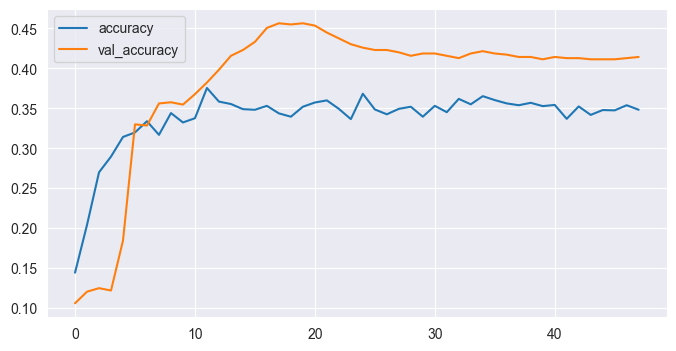

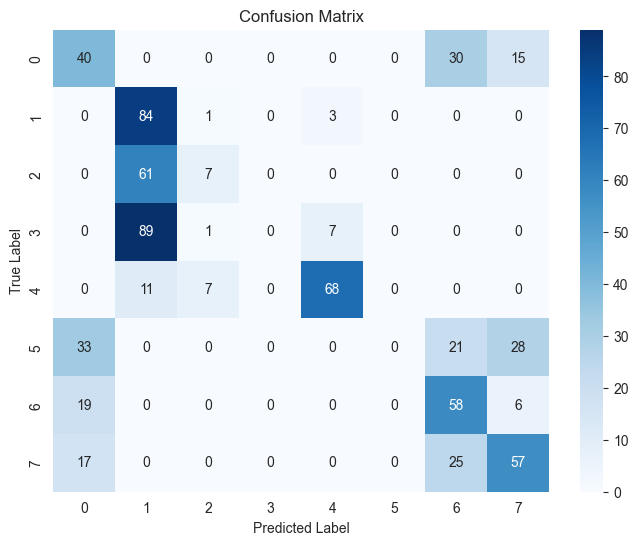

In [5]:
X_train, y_train, X_test, y_test  = utils.split_data(X, y, train_ratio=0.8)
X_train, y_train = filtering_zero(X_train, y_train, erase_label=0)
X_test, y_test = filtering_zero(X_test, y_test, erase_label=0)

model = Model.Original_model(X_train.shape[1:], num_class=np.max(y_train)+1)

history, model = Model.Train_model(
    model, X_train, y_train, X_test, y_test,
    set_epoch=100, set_batch_size=256, Model_name='V0',
    set_verbose=False, save_model_set=False
)
vis_graph(history)
heatmap_confusion_matrix(X_test, y_test, model)